# **Predictive Analysis #2**

>***UC-Irvine Online Shoppers Purchasing Intention Dataset***

In Predictive Analysis#1 we used all available independent variables in the machine learning models. In this step, we will apply feature selection using corrolation results and Chi-Squared test results. (Please refer to EDA 2 notebook for corrolation results)

#Importing libraries and dataset

**Importing required libraries**

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import copy

from pandas.core.frame import DataFrame
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import plot_confusion_matrix


**Reading the dataset to Pandas dataframe**

In [156]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
df_original = pd.read_csv (url)

**Making a copy to keep the original if needed.**

In [157]:
df_c=df_original.copy()

**In EDA we concluded that:**
* The Revenue is independent of "Region" using Chi-Squared test
* The ExitRates and BounceRates are highly corrolated. Hence we decided to keep ExitRates due to higher variance. 
* The ProductRelated and ProductRelated_Duration are highly corrolated. Hence we decided to keep ProductRelated due to higher variance.

**We will drop these columns from the dataset.**

In [158]:

excluded_var = ["BounceRates","Region", "ProductRelated_Duration"]
df_c=df_c.drop(columns=excluded_var)

# Preprocessing the dataset

**Data Normalization**

In [159]:
from sklearn.preprocessing import Normalizer
#defining the preprocessor 
Normalizer=Normalizer()

#creating a list of numerical features 
numeric_features = ["Administrative", "Administrative_Duration", 
                    "Informational", "Informational_Duration", "ProductRelated", 
                    "ExitRates", "PageValues", "SpecialDay", 
                    "Browser", "OperatingSystems","TrafficType"]

#normalizing the numerical features 
df_c[numeric_features]=Normalizer.fit_transform(df_c[numeric_features])


**Creating a temporary dataframe from only the dependent variable so it can be re-added as the last column of the finalized dataframe**

In [160]:
temp_y=df_c[["Revenue"]]


**Transforming the non-numeric categorical features to dummy variables**

In [161]:
#Defining dummy values for all non-numeric  categorical variables 
Month=pd.get_dummies(df_c["Month"], drop_first=True)
VisitorType=pd.get_dummies(df_c["VisitorType"], drop_first=True)
Weekend=pd.get_dummies(df_c["Weekend"],  prefix="Weekend", drop_first=True)

**Dropping the original variables, and dependent variable (so it can be added back as the last column)**

In [162]:
#dropping the original variables, and dependent variable
df_c.drop(["Month", "VisitorType", "Weekend", "Revenue"], axis=1, inplace=True)

**Adding the newly created dummy variables to the dataset, and adding dependent variable to the end**

In [163]:
#adding the newly created dummy variables to the dataset, and adding dependent variable to the end
df_c=pd.concat([df_c, Month, VisitorType, Weekend, temp_y],axis=1)

**Let's take a look at the transformed dataset before we proceed**

In [164]:
df_c

Administrative  Administrative_Duration  Informational  \
0            0.000000                 0.000000            0.0   
1            0.000000                 0.000000            0.0   
2            0.000000                 0.000000            0.0   
3            0.000000                 0.000000            0.0   
4            0.000000                 0.000000            0.0   
...               ...                      ...            ...   
12325        0.019346                 0.935078            0.0   
12326        0.000000                 0.000000            0.0   
12327        0.000000                 0.000000            0.0   
12328        0.051661                 0.968649            0.0   
12329        0.000000                 0.000000            0.0   

       Informational_Duration  ProductRelated  ExitRates  PageValues  \
0                         0.0        0.497519   0.099504    0.000000   
1                         0.0        0.499844   0.024992    0.000000   
2                         0.0        0.192308   0.038462    0.000000   
3                         0.0        0.348052   0.024364    0.000000   
4                         0.0        0.863860   0.004319    0.000000   
...                       ...             ...        ...         ...   
12325                     0.0        0.341787   0.000187    0.078945   
12326                     0.0        0.495073   0.002112    0.000000   
12327                     0.0        0.406364   0.005870    0.000000   
12328                     0.0        0.193730   0.000272    0.000000   
12329                     0.0        0.588298   0.013073    0.000000   

       SpecialDay  OperatingSystems   Browser  ...  June  Mar  May  Nov  Oct  \
0             0.0          0.497519  0.497519  ...     0    0    0    0    0   
1             0.0          0.499844  0.499844  ...     0    0    0    0    0   
2             0.0          0.769231  0.192308  ...     0    0    0    0    0   
3             0.0          0.522078  0.348052  ...     0    0    0    0    0   
4             0.0          0.259158  0.259158  ...     0    0    0    0    0   
...           ...               ...       ...  ...   ...  ...  ...  ...  ...   
12325         0.0          0.025795  0.038693  ...     0    0    0    0    0   
12326         0.0          0.297044  0.198029  ...     0    0    0    1    0   
12327         0.0          0.203182  0.135455  ...     0    0    0    1    0   
12328         0.0          0.025831  0.025831  ...     0    0    0    1    0   
12329         0.0          0.588298  0.392199  ...     0    0    0    1    0   

       Sep  Other  Returning_Visitor  Weekend_True  Revenue  
0        0      0                  1             0    False  
1        0      0                  1             0    False  
2        0      0                  1             0    False  
3        0      0                  1             0    False  
4        0      0                  1             1    False  
...    ...    ...                ...           ...      ...  
12325    0      0                  1             1    False  
12326    0      0                  1             1    False  
12327    0      0                  1             1    False  
12328    0      0                  1             0    False  
12329    0      0                  0             1    False  

[12330 rows x 24 columns]

#ML Parameters

* **we set random state for the result to be repeatable**

In [165]:
# Set a Random State 
rng = np.random.RandomState(0)


* **Let's separate our dependent variable, and split our data to train set and test set.** 
* **we will keep this 20% test set to evaluate and compare the performance of  all models.**

In [166]:
from sklearn.model_selection import train_test_split

# Divide X and y (separating dependent variable from independent variables)
y = df_c['Revenue']
X = df_c.drop(['Revenue'], axis=1)


# Split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=rng)

* **We will use Accuracy,precision, recall, F1 score, and AUC-ROC(Area Under the Curve of Receiver Operating Characteristics) as evaluation measure to compare our models.**
* **We are also using 10 fold cross validation, repeated 3 times, to train our models. Please note we set randm_state to ensure our folds stay the same for all models.**

In [167]:
#creating a list of evaluation measures to pass on to ML pipelines
scoring = ('roc_auc','accuracy','precision','recall', "f1")

#creating repeated K fold Cross validation with random state to pass on to ML pieplines 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=rng)

**As shown in the EDA, our data set is extremely imbalanced. Hence, we will apply SMOTE on our train dataset before training each model by adding the SMOTE function to all our Machine Learning pieplines.**

#XGB Classifier

**Let's pass on the data to XGB  (Extreme Gradient Boosting) Classifier**

In [168]:
#defining the classifier 
XGB=XGBClassifier(eval_metric='logloss', max_depth=27)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", XGB)]

#defining the pipeline
clf_XGB= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_XGB = cross_validate(clf_XGB, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_XGB.items():
    print(k, np.round(v.mean(),4))


fit_time 11.6118
score_time 0.0391
test_roc_auc 0.9219
test_accuracy 0.8782
test_precision 0.574
test_recall 0.7482
test_f1 0.6489


* **We see the average result of all folds performed by using the training and validation set of each fold**

**Since the results are acceptable, in the next step, we pass on the test set to assess our model, and calculate the evaluation measures which would be the measures to compare the performance of the models on unseen data** 

In [169]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
XGB_fit=XGB.fit(X_train, y_train)


**Predicting the independent variable "Revenue" using test set**

In [170]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_XGB = XGB_fit.predict(X_test)

**Displaying the results as Confusion Matrix**

In [171]:
from sklearn.metrics import confusion_matrix, accuracy_score
# Confusion Matrix
cm_XGB=confusion_matrix(y_test, y_pred_XGB)
cm_XGB

array([[1943,  101],
       [ 187,  235]])

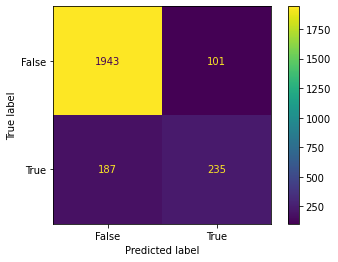

In [172]:
from sklearn.metrics import ConfusionMatrixDisplay
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_XGB);

**Let's get the evaluation measures for the model:**

In [173]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#getting the evaluation measures for test set
XGB_Metrics= classification_report(y_test, y_pred_XGB, digits=3)
XGB_ROC_AUC= round(roc_auc_score(y_test, y_pred_XGB),3)

#printing the evaluation measures for test set
print("XGBClassifier\n\n", XGB_Metrics)
print("roc_auc    ", XGB_ROC_AUC )

XGBClassifier

               precision    recall  f1-score   support

       False      0.912     0.951     0.931      2044
        True      0.699     0.557     0.620       422

    accuracy                          0.883      2466
   macro avg      0.806     0.754     0.776      2466
weighted avg      0.876     0.883     0.878      2466

roc_auc     0.754


**Saving the model performance result in a dictionary**

In [174]:
#saving the model performance result in a dictionary for easy future access
XGB_report= classification_report(y_test, y_pred_XGB, digits=3, output_dict=True)


**NOTE: All the above steps will be repeated for each model.**

**For this model, let's plot the XGB tree!**

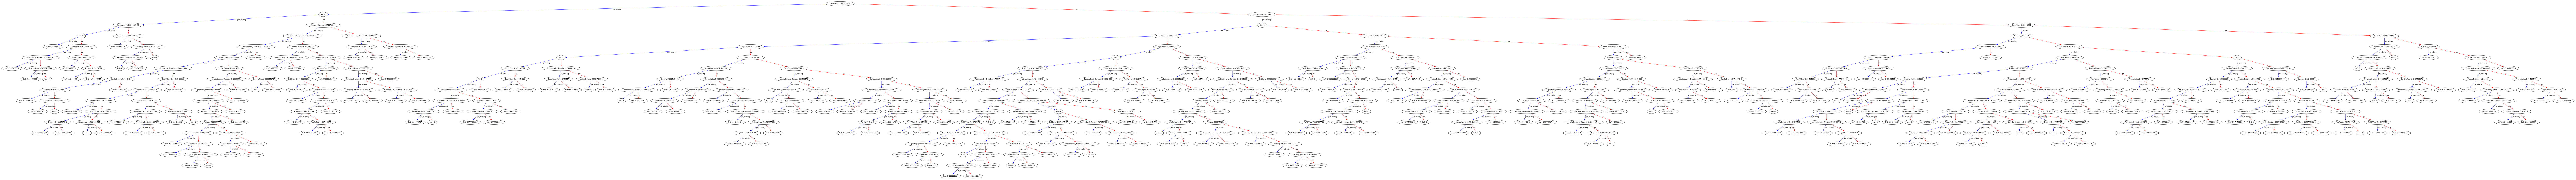

In [175]:
from xgboost import plot_tree
#Plotting the XGB tree
plot_tree(XGB);
fig = plt.gcf()
fig.set_size_inches(300, 300)
fig.savefig('XGBtree.png')

#Random Forest Classifier

In [176]:
from sklearn.ensemble import RandomForestClassifier

#defining the classifier 
RF=RandomForestClassifier(random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", RF)]

#defining the pipeline
clf_RF= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_RF = cross_validate(clf_RF, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_RF.items():
    print(k, np.round(v.mean(),4))

fit_time 2.8874
score_time 0.0737
test_roc_auc 0.9231
test_accuracy 0.8849
test_precision 0.5901
test_recall 0.7713
test_f1 0.6681


In [177]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
RF_fit=RF.fit(X_train, y_train)

In [178]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_RF = RF_fit.predict(X_test)

In [179]:
# Confusion Matrix
cm_RF=confusion_matrix(y_test, y_pred_RF)
cm_RF

array([[1964,   80],
       [ 204,  218]])

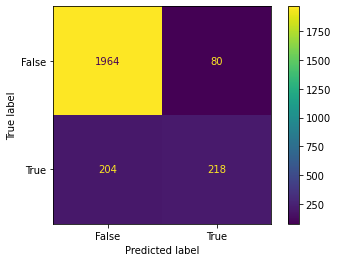

In [180]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF);

In [181]:
#getting the evaluation measures for test set
RF_Metrics= classification_report(y_test, y_pred_RF, digits=3)
RF_ROC_AUC= round(roc_auc_score(y_test, y_pred_RF),3)

#printing the evaluation measures for test set
print("RandomForestClassifier\n\n", RF_Metrics)
print("roc_auc    ", RF_ROC_AUC )

RandomForestClassifier

               precision    recall  f1-score   support

       False      0.906     0.961     0.933      2044
        True      0.732     0.517     0.606       422

    accuracy                          0.885      2466
   macro avg      0.819     0.739     0.769      2466
weighted avg      0.876     0.885     0.877      2466

roc_auc     0.739


In [182]:
#saving the model performance result in a dictionary for easy future access
RF_report= classification_report(y_test, y_pred_RF, digits=3, output_dict=True)

#Desicion Tree Classifier

In [183]:
#defining the classifier 
DT=DecisionTreeClassifier(random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", DT)]

#defining the pipeline
clf_DT= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_DT = cross_validate(clf_DT, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_DT.items():
    print(k, np.round(v.mean(),4))

fit_time 0.321
score_time 0.0103
test_roc_auc 0.7753
test_accuracy 0.8516
test_precision 0.5057
test_recall 0.6657
test_f1 0.5742


In [184]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
DT_fit= DT.fit(X_train, y_train)


In [185]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_DT = DT_fit.predict(X_test)

In [186]:
# Confusion Matrix
cm_DT=confusion_matrix(y_test, y_pred_DT)
cm_DT

array([[1869,  175],
       [ 187,  235]])

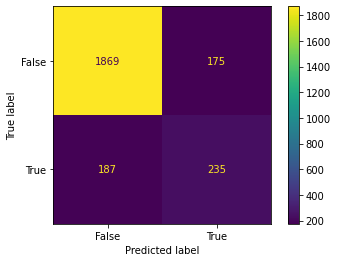

In [187]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_DT);

In [188]:
#getting the evaluation measures for test set
DT_Metrics= classification_report(y_test, y_pred_DT, digits=3)
DT_ROC_AUC= round(roc_auc_score(y_test, y_pred_DT),3)

#printing the evaluation measures for test set
print("DecisionTreeClassifier\n\n", DT_Metrics)
print("roc_auc    ", DT_ROC_AUC )

DecisionTreeClassifier

               precision    recall  f1-score   support

       False      0.909     0.914     0.912      2044
        True      0.573     0.557     0.565       422

    accuracy                          0.853      2466
   macro avg      0.741     0.736     0.738      2466
weighted avg      0.852     0.853     0.852      2466

roc_auc     0.736


In [189]:
#saving the model performance result in a dictionary for easy future access
DT_report= classification_report(y_test, y_pred_DT, digits=3, output_dict=True)

#Support Vector Classification

In [190]:
from sklearn import svm

#defining the classifier 
SVC_L=svm.SVC(kernel='linear', random_state=rng)

#steps in the pipeline 
steps=[('SMOTE', SMOTE(random_state=rng)),("classifier", SVC_L)]

#defining the pipeline
clf_SVC_L= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_SVC_L = cross_validate(clf_SVC_L, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_SVC_L.items():
    print(k, np.round(v.mean(),4))

fit_time 6.2006
score_time 0.4056
test_roc_auc 0.8997
test_accuracy 0.8234
test_precision 0.45
test_recall 0.7748
test_f1 0.5689


In [191]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
SVC_fit=SVC_L.fit(X_train, y_train)


In [192]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_SVC_L = SVC_fit.predict(X_test)

In [193]:
# Confusion Matrix
cm_SVC_L=confusion_matrix(y_test, y_pred_SVC_L)
cm_SVC_L

array([[1999,   45],
       [ 277,  145]])

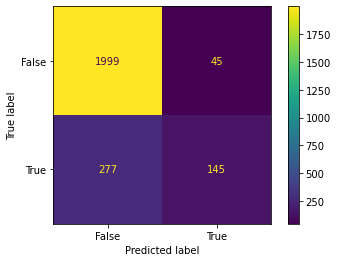

In [194]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_SVC_L);

In [195]:
#getting the evaluation measures for test set
SVC_L_Metrics= classification_report(y_test, y_pred_SVC_L, digits=3)
SVC_L_ROC_AUC= round(roc_auc_score(y_test, y_pred_SVC_L),3)

#printing the evaluation measures for test set
print("Support Vector Classification \n\n", SVC_L_Metrics)
print("roc_auc    ", SVC_L_ROC_AUC )

Support Vector Classification 

               precision    recall  f1-score   support

       False      0.878     0.978     0.925      2044
        True      0.763     0.344     0.474       422

    accuracy                          0.869      2466
   macro avg      0.821     0.661     0.700      2466
weighted avg      0.859     0.869     0.848      2466

roc_auc     0.661


In [196]:
#saving the model performance result in a dictionary for easy future access
SVC_L_report= classification_report(y_test, y_pred_SVC_L, digits=3, output_dict=True)

#LogisticRegression

In [197]:
from sklearn.linear_model import LogisticRegression

#defining the classifier 
LR=LogisticRegression(random_state=rng, max_iter=2000)

#steps in the pipeline 
steps=[('SMOTE', SMOTE( random_state=rng)),("classifier", LR)]

#defining the pipeline
clf_LR= Pipeline(steps=steps)

#results from training the model using cross_validation and the predefined pipeline 
scores_LR = cross_validate(clf_LR, X_train, y_train, cv=cv, scoring=scoring)

#printing the scores from the result of model training with cross validation
for k, v in scores_LR.items():
    print(k, np.round(v.mean(),4))

fit_time 0.6265
score_time 0.0198
test_roc_auc 0.8966
test_accuracy 0.8276
test_precision 0.457
test_recall 0.7628
test_f1 0.571


In [198]:
#Fit the model on the Training set (loading the model) before calling the model for prediction
LR_fit=LR.fit(X_train, y_train)

In [199]:
#predicting the independent variable "Revenue" using the fitted piepline! :)
y_pred_LR = LR_fit.predict(X_test)

In [200]:
# Confusion Matrix
cm_LR=confusion_matrix(y_test, y_pred_LR)
cm_LR

array([[1996,   48],
       [ 268,  154]])

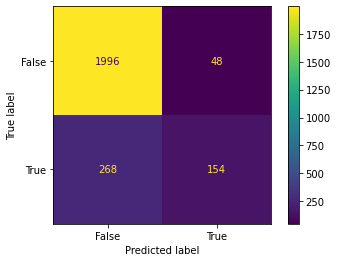

In [201]:
#Displaying the results of Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_LR);

In [202]:
#getting the evaluation measures for test set
LR_Metrics= classification_report(y_test, y_pred_LR, digits=3)
LR_ROC_AUC= round(roc_auc_score(y_test, y_pred_LR),3)

#printing the evaluation measures for test set
print("Logistic Regression Classifier \n\n", LR_Metrics)
print("roc_auc    ", LR_ROC_AUC )

Logistic Regression Classifier 

               precision    recall  f1-score   support

       False      0.882     0.977     0.927      2044
        True      0.762     0.365     0.494       422

    accuracy                          0.872      2466
   macro avg      0.822     0.671     0.710      2466
weighted avg      0.861     0.872     0.853      2466

roc_auc     0.671


In [203]:
#saving the model performance result in a dictionary for easy future access
LR_report= classification_report(y_test, y_pred_LR, digits=3, output_dict=True)

#Comparing the Models 

In [204]:
from tabulate import tabulate

In [208]:
#create data
data = [["XGB", XGB_report["accuracy"], XGB_report["False"]["recall"],
         XGB_report["True"]["recall"], XGB_report["False"]["precision"], 
         XGB_report["True"]["precision"], XGB_report["False"]["f1-score"], 
         XGB_report["True"]["f1-score"], XGB_ROC_AUC],
        
        ["RF", RF_report["accuracy"], RF_report["False"]["recall"], 
         RF_report["True"]["recall"], RF_report["False"]["precision"], 
         RF_report["True"]["precision"], RF_report["False"]["f1-score"], 
         RF_report["True"]["f1-score"], RF_ROC_AUC], 
        
        ["DT", DT_report["accuracy"], DT_report["False"]["recall"], 
         DT_report["True"]["recall"], DT_report["False"]["precision"], 
         DT_report["True"]["precision"], DT_report["False"]["f1-score"], 
         DT_report["True"]["f1-score"], DT_ROC_AUC], 
        
        ["SVC_L", SVC_L_report["accuracy"], 
         SVC_L_report["False"]["recall"], SVC_L_report["True"]["recall"], 
         SVC_L_report['False']["precision"], SVC_L_report["True"]["precision"],
         SVC_L_report["False"]["f1-score"], SVC_L_report["True"]["f1-score"], 
         SVC_L_ROC_AUC],
        
        ["Logit", LR_report["accuracy"], LR_report["False"]["recall"], 
         LR_report["True"]["recall"], LR_report["False"]["precision"], 
         LR_report["True"]["precision"], LR_report["False"]["f1-score"], 
         LR_report["True"]["f1-score"], LR_ROC_AUC]]
  
#define header names
col_names = ["Classifier", "Accuracy", "Recall(F)", 
             "Recall(T)", "Precision(F)",
             "Precision(T)", "F1(F)", 
             "F1(T)", "ROC_AUC"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


╒══════════════╤════════════╤═════════════╤═════════════╤════════════════╤════════════════╤══════════╤══════════╤═══════════╕
│ Classifier   │   Accuracy │   Recall(F) │   Recall(T) │   Precision(F) │   Precision(T) │    F1(F) │    F1(T) │   ROC_AUC │
╞══════════════╪════════════╪═════════════╪═════════════╪════════════════╪════════════════╪══════════╪══════════╪═══════════╡
│ XGB          │   0.883212 │    0.950587 │    0.556872 │       0.912207 │       0.699405 │ 0.931001 │ 0.620053 │     0.754 │
├──────────────┼────────────┼─────────────┼─────────────┼────────────────┼────────────────┼──────────┼──────────┼───────────┤
│ RF           │   0.884834 │    0.960861 │    0.516588 │       0.905904 │       0.731544 │ 0.932574 │ 0.605556 │     0.739 │
├──────────────┼────────────┼─────────────┼─────────────┼────────────────┼────────────────┼──────────┼──────────┼───────────┤
│ DT           │   0.853204 │    0.914384 │    0.556872 │       0.909047 │       0.573171 │ 0.911707 │ 0.564904 │     

**In this analysis we used 14 independent variables (out of 17 in the original dataset)**

**In the next predictive analysis we will look into another feature selection option with the purpose of improving the performance of our models.** 